In [55]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime

import plotly
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as offline
offline.init_notebook_mode()
from plotly import tools
import plotly.tools as tls

import folium
from folium import plugins
from folium.plugins import HeatMap

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("./data"))

['immigrants_emigrants_by_destination.csv', 'air_stations_Nov2017.csv', 'most_frequent_baby_names.csv', 'bus_stops.csv', 'life_expectancy.csv', 'transports.csv', 'most_frequent_names.csv', 'unemployment.csv', 'immigrants_by_nationality.csv', 'immigrants_emigrants_by_destination2.csv', 'accidents_2017.csv', 'deaths.csv', 'immigrants_emigrants_by_age.csv', 'air_quality_Nov2017.csv', 'population.csv', 'births.csv', 'immigrants_emigrants_by_sex.csv']


In [2]:
population = pd.read_csv("./data/population.csv", 
                       sep=",", encoding="UTF-8")
immigrants_emigrants_by_sex = pd.read_csv("./data/immigrants_emigrants_by_sex.csv", 
                                        sep=",", encoding="UTF-8")
immigrants_emigrants_by_age = pd.read_csv("./data/immigrants_emigrants_by_age.csv", 
                                        sep=",", encoding="UTF-8")
immigrants_emigrants_by_destination = pd.read_csv("./data/immigrants_emigrants_by_destination.csv", 
                                                sep=",", encoding="UTF-8")
immigrants_emigrants_by_destination2 = pd.read_csv("./data/immigrants_emigrants_by_destination2.csv", 
                                                 sep=",", encoding="UTF-8")
immigrants_by_nationality = pd.read_csv("./data/immigrants_by_nationality.csv", 
                                      sep=",", encoding="UTF-8")
births = pd.read_csv("./data/births.csv", sep=",", encoding="UTF-8")
deaths = pd.read_csv("./data/deaths.csv", sep=",", encoding="UTF-8")
unemployment = pd.read_csv("./data/unemployment.csv", sep=",", encoding="UTF-8")
baby_names = pd.read_csv("./data/most_frequent_baby_names.csv", sep=",")
names = pd.read_csv("./data/most_frequent_names.csv", sep=",")
life_expectancy = pd.read_csv("./data/life_expectancy.csv", sep=",", encoding="UTF-8")

In [3]:
population.head()

Year  District.Code District.Name  Neighborhood.Code  \
0  2017              1  Ciutat Vella                  1   
1  2017              1  Ciutat Vella                  2   
2  2017              1  Ciutat Vella                  3   
3  2017              1  Ciutat Vella                  4   
4  2017              2      Eixample                  5   

                       Neighborhood.Name Gender  Age  Number  
0                               el Raval   Male  0-4     224  
1                         el Barri Gòtic   Male  0-4      50  
2                         la Barceloneta   Male  0-4      43  
3  Sant Pere, Santa Caterina i la Ribera   Male  0-4      95  
4                          el Fort Pienc   Male  0-4     124

In [4]:
total_pop = population[population['Year'] == 2017]['Number'].sum()
print("Total Population of Barcelona =",total_pop)

Total Population of Barcelona = 1620809


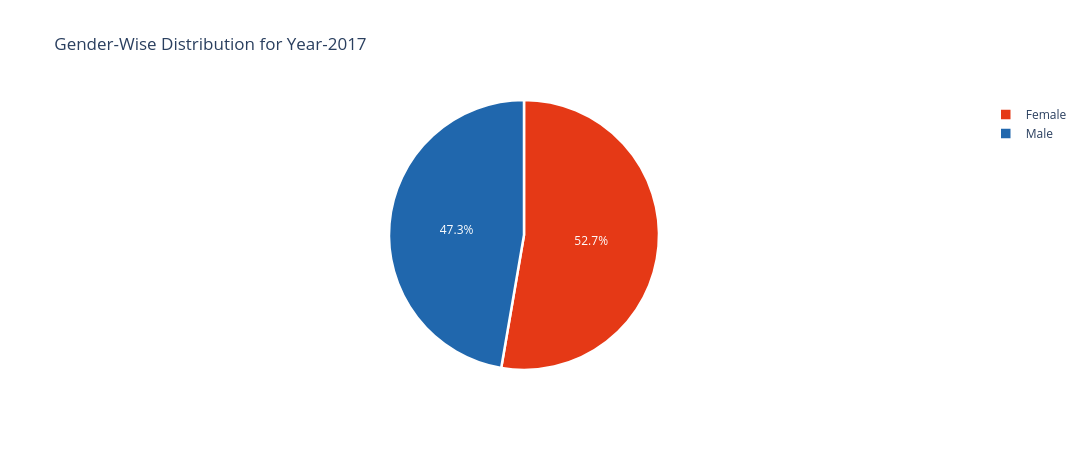

In [5]:
temp_df = population[population['Year'] == 2017].groupby(['Gender'])['Number'].sum()

trace = go.Pie(labels = temp_df.index,
               values = temp_df.values,
               marker = dict(colors=['#E53916','#2067AD'], line = dict(color='#FFFFFF', width=2.5))
              )

data = [trace]
layout = go.Layout(title="Gender-Wise Distribution for Year-2017")
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)

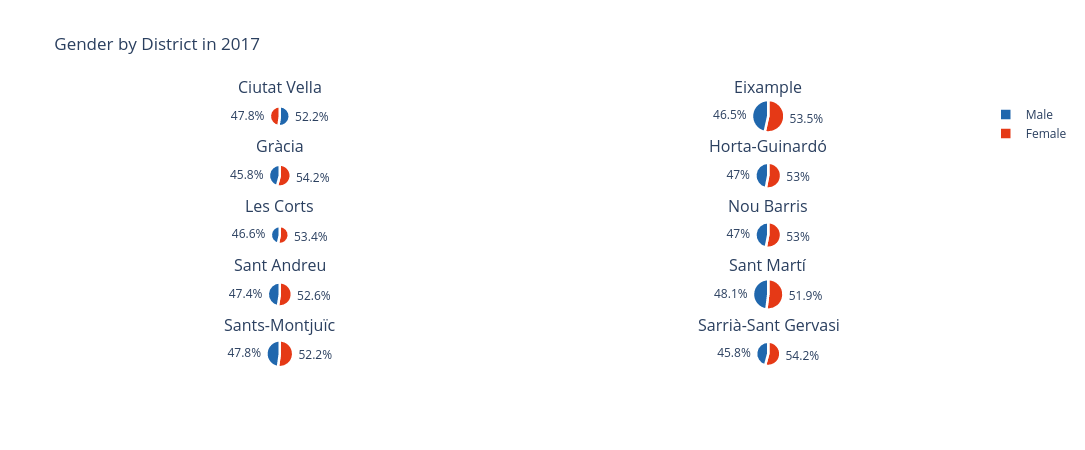

In [6]:
temp_df = population[population['Year'] == 2017].groupby(['Gender', 'District.Name'])['Number'].sum()

Districts = temp_df.index.levels[1]
Genders = temp_df.index.levels[0]

pies_per_line = 2
specs = []

for i in range(Districts.size):
    if i%pies_per_line == 0:
        specs.append([])
    specs[int(i/pies_per_line)].append({'type':'domain'})

fig = make_subplots(
    round(Districts.size/pies_per_line), 
    pies_per_line, 
    specs=specs,
    subplot_titles=list(Districts.array))

for i, district in enumerate(Districts):
    fig.add_trace(
        go.Pie(
            labels=Genders, 
            values=temp_df.xs(district, level='District.Name').values,
            marker = dict(
                colors=['#E53916','#2067AD'], 
                line = dict(color='#FFFFFF', width=2.5)
            ),
            scalegroup='one',
            name=district), 
        int(i/pies_per_line) + 1,  # col
        1 + (i%pies_per_line))     # row 

fig.update_layout(title_text='Gender by District in 2017')

plotly.offline.iplot(fig)

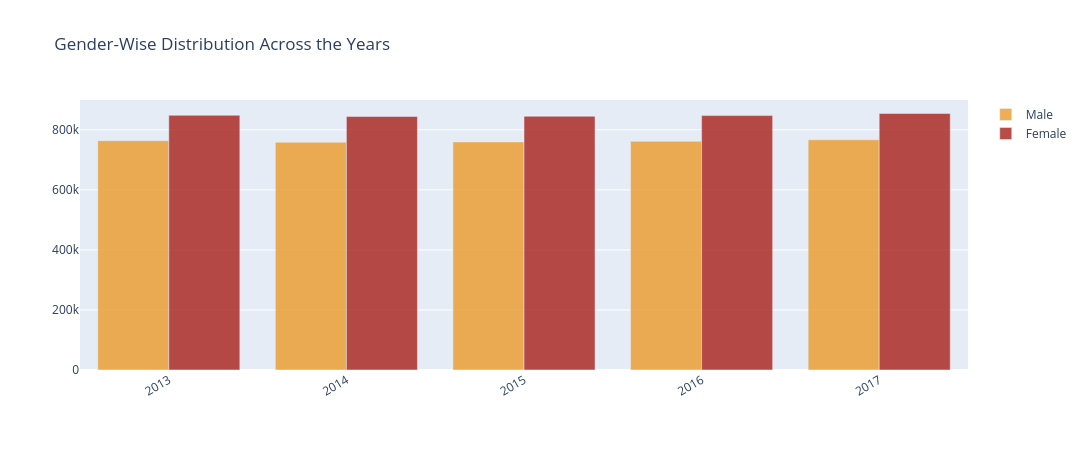

In [7]:
male = population[population['Gender'] == 'Male'].groupby(['Year'])['Number'].sum()
female = population[population['Gender'] == 'Female'].groupby(['Year'])['Number'].sum()

trace0 = go.Bar(x = male.index,
                y= male.values,
                name = "Male",
                marker = dict(color='rgb(236,154,41)'),
                opacity = 0.8
               )

trace1 = go.Bar(x = female.index,
                y = female.values,
                name = "Female",
                marker = dict(color='rgb(168,32,26)'),
                opacity = 0.8
               )

data = [trace0,trace1]
layout = go.Layout(barmode = 'group',
                   xaxis = dict(tickangle=-30),
                   title="Gender-Wise Distribution Across the Years",
                      )
fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

### Insights

- Everywhere but in the district of Ciutat Vella, there are more women than men
- This numbers didn't change much over the years

## Which district holds the highest number of population?

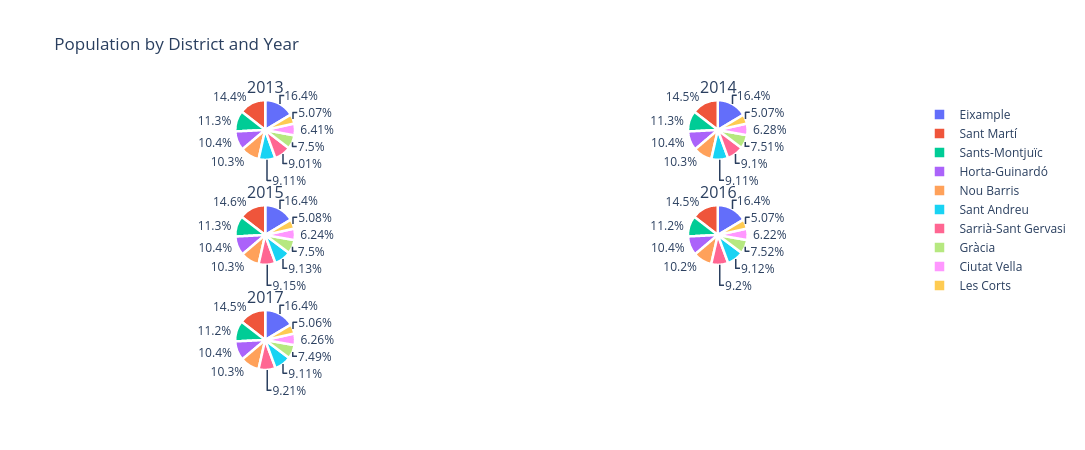

In [8]:
dist_df = population.groupby(['District.Name','Year'])['Number'].sum()

Districts = dist_df.index.levels[0]
Years = dist_df.index.levels[1]

pies_per_line = 2
specs = []

for i in range(Years.size + 1):
    if i%pies_per_line == 0:
        specs.append([])
    specs[int(i/pies_per_line)].append({'type':'domain'})

fig = make_subplots(
    math.ceil(Years.size/pies_per_line), 
    pies_per_line, 
    specs=specs,
    subplot_titles=list(Years.array.astype(str)))

for i, year in enumerate(Years):
    fig.add_trace(
        go.Pie(
            labels=Districts, 
            values=dist_df.xs(year, level='Year').values,
            marker = dict(
#                 colors=['#E53916','#2067AD'], 
                line = dict(color='#FFFFFF', width=2.5)
            ),
            scalegroup='one',
            name=year), 
        int(i/pies_per_line) + 1,  # col
        1 + (i%pies_per_line))     # row 

fig.update_layout(title_text='Population by District and Year')

plotly.offline.iplot(fig)

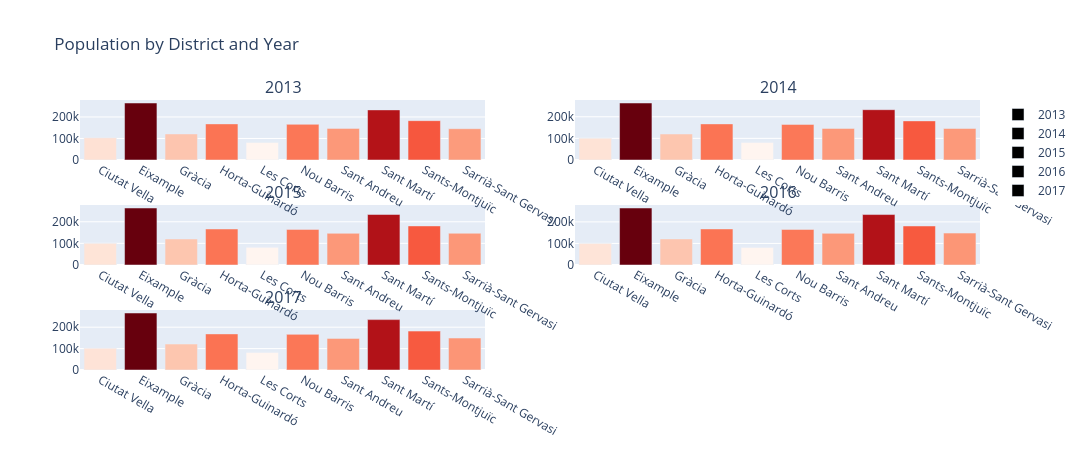

In [9]:
dist_df = population.groupby(['District.Name','Year'])['Number'].sum()

Districts = dist_df.index.levels[0]
Years = dist_df.index.levels[1]

pies_per_line = 2

fig = make_subplots(
    math.ceil(Years.size/pies_per_line), 
    pies_per_line, 
#     specs=specs,
    subplot_titles=list(Years.array.astype(str)))

for i, year in enumerate(Years):
    fig.add_trace(
        go.Bar(
            x = Districts, 
            y = dist_df.xs(year, level='Year').values,
            marker = dict(
                color=list(dist_df.xs(year, level='Year').values), 
                colorscale='Reds'),
            name=year), 
        int(i/pies_per_line) + 1,  # col
        1 + (i%pies_per_line))     # row 

fig.update_layout(title_text='Population by District and Year')

plotly.offline.iplot(fig)

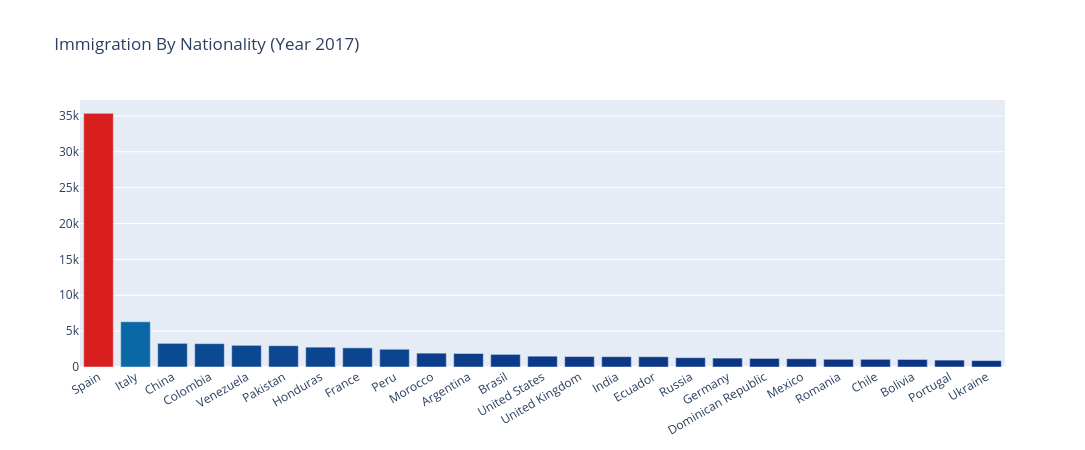

In [10]:
im_df = immigrants_by_nationality[immigrants_by_nationality['Year'] == 2017].groupby([
    'Nationality'])['Number'].sum().sort_values(axis=0, ascending=False)[:25]

trace0 = go.Bar(x = im_df.index,
                y = im_df.values,
                marker = dict(color=list(im_df.values),
                                  colorscale='Portland'),
                )

data = [trace0]
layout = go.Layout(xaxis = dict(tickangle=-30),
                   title="Immigration By Nationality (Year 2017)",
                      )
fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

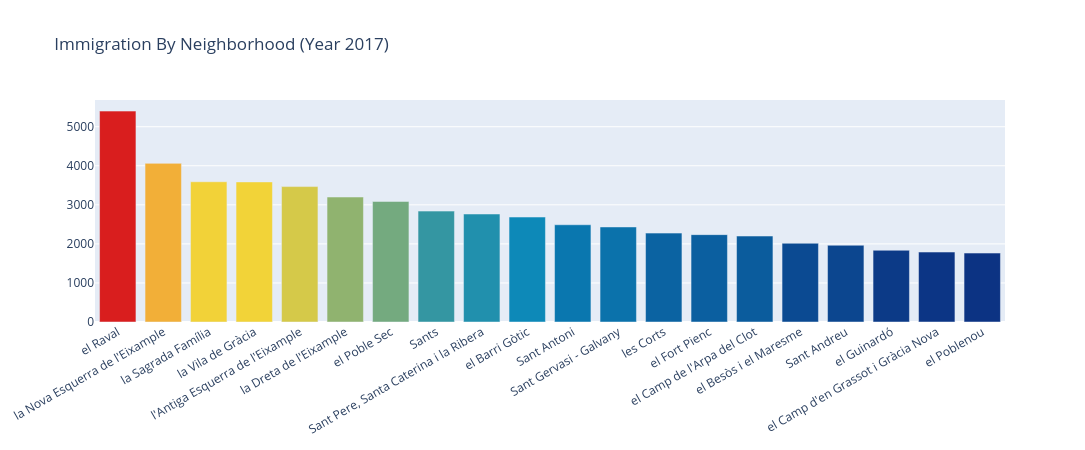

In [11]:
im_df = immigrants_by_nationality[immigrants_by_nationality['Year'] == 2017].groupby([
    'Neighborhood Name'])['Number'].sum().sort_values(axis=0, ascending=False)[:20]

trace0 = go.Bar(x = im_df.index,
                y = im_df.values,
                marker = dict(color=list(im_df.values),
                                  colorscale='Portland'),
                )

data = [trace0]
layout = go.Layout(xaxis = dict(tickangle=-30),
                   title="Immigration By Neighborhood (Year 2017)",
                      )
fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

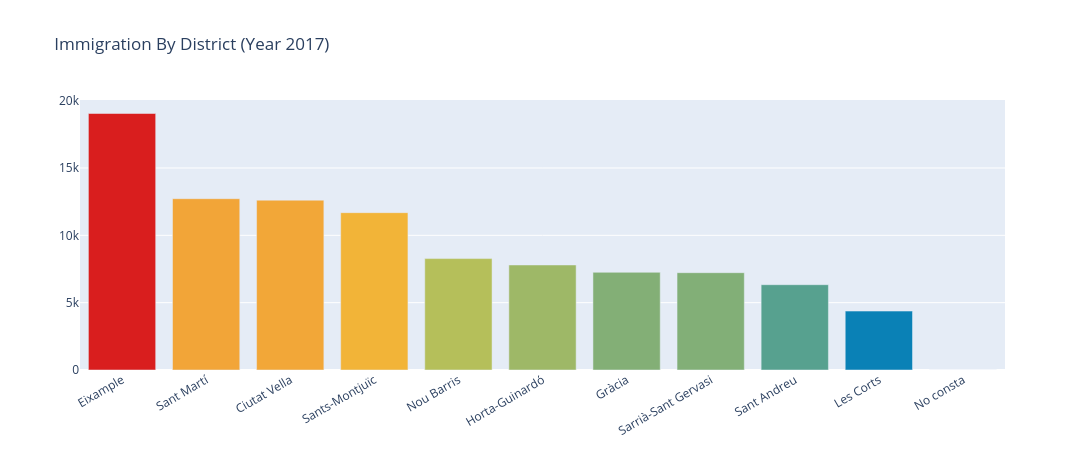

In [12]:
im_df = immigrants_by_nationality[immigrants_by_nationality['Year'] == 2017].groupby([
    'District Name'])['Number'].sum().sort_values(axis=0, ascending=False)

trace0 = go.Bar(x = im_df.index,
                y = im_df.values,
                marker = dict(color=list(im_df.values),
                                  colorscale='Portland'),
                )

data = [trace0]
layout = go.Layout(xaxis = dict(tickangle=-30),
                   title="Immigration By District (Year 2017)",
                      )
fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

In [13]:
transports = pd.read_csv('./data/transports.csv')
transports.head()

Code    Transport  Longitude   Latitude  \
0  K001  Underground   2.119370  41.399203   
1  K001  Underground   2.135427  41.397791   
2  K001  Underground   2.185391  41.451492   
3  K001  Underground   2.174473  41.460889   
4  K001  Underground   2.168588  41.387200   

                                             Station        District.Name  \
0  FGC (L6) - REINA ELISENDA (Sortida Duquesa d'O...  Sarrià-Sant Gervasi   
1                            FGC (L6) - LA BONANOVA-  Sarrià-Sant Gervasi   
2      METRO (L11) - CASA DE L'AIGUA (C. Vila-Real)-           Nou Barris   
3    METRO (L11) - CIUTAT MERIDIANA (C. Pedraforca)-           Nou Barris   
4         METRO (L1) - CATALUNYA (Rda. Universitat)-             Eixample   

        Neighborhood.Name  
0                  Sarrià  
1  Sant Gervasi - Galvany  
2        la Trinitat Nova  
3        Ciutat Meridiana  
4  la Dreta de l'Eixample

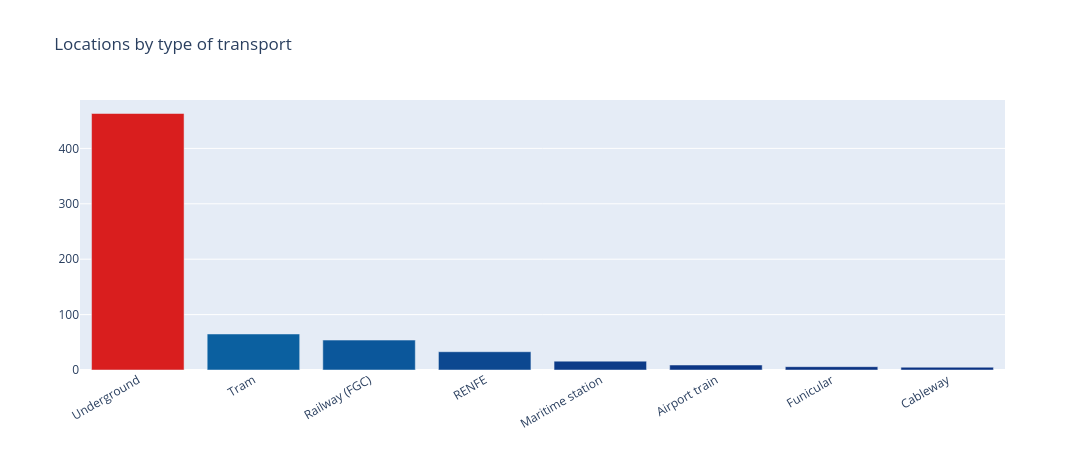

In [14]:
temp_df = transports['Transport'].value_counts()

trace0 = go.Bar(x = temp_df.index,
                y = temp_df.values,
                marker = dict(color=list(temp_df.values),
                                  colorscale='Portland'),
                )

data = [trace0]
layout = go.Layout(xaxis = dict(tickangle=-30),
                   title="Locations by type of transport",
                      )
fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

In [15]:
barcelona_coordinates = [41.3851, 2.1734]

geo_transport = gpd.GeoDataFrame(transports)
geo_transport['geometry'] = gpd.points_from_xy(transports['Longitude'], transports['Latitude'])
geo_transport.crs = {'init':'epsg:4326'}

m = folium.Map(location=barcelona_coordinates)

folium.features.GeoJson(
    data=geo_transport,
    style_function=lambda x :{'fillColor':'green' if \
                              x['properties']['Transport'] == 'Underground' \
                              else 'orange' if x['properties']['Transport'] == 'Bus' else 'red'},
    tooltip=folium.features.GeoJsonTooltip([
        'Transport',
        'Station'
    ])
).add_to(m)

m.save('transport_in_barcelona.html')
m

In [16]:
accidents = pd.read_csv('./data/accidents_2017.csv')
accidents.head()

Id District Name           Neighborhood Name  \
0  2017S008429           Unknown                     Unknown   
1  2017S007316           Unknown                     Unknown   
2  2017S010210           Unknown                     Unknown   
3  2017S006364           Unknown                     Unknown   
4  2017S004615        Sant Martí  el Camp de l'Arpa del Clot   

                                              Street   Weekday      Month  \
0  Número 27                                     ...    Friday    October   
1  Número 3 Zona Franca / Número 50 Zona Franca  ...    Friday  September   
2  Litoral (Besòs)                               ...    Friday   December   
3  Número 3 Zona Franca                          ...    Friday       July   
4  Las Navas de Tolosa                           ...  Thursday        May   

   Day  Hour Part of the day  Mild injuries  Serious injuries  Victims  \
0   13     8         Morning              2                 0        2   
1    1    13         Morning              2                 0        2   
2    8    21       Afternoon              5                 0        5   
3   21     2           Night              1                 0        1   
4   25    14       Afternoon              1                 0        1   

   Vehicles involved  Longitude   Latitude  
0                  2   2.125624  41.340045  
1                  2   2.120452  41.339426  
2                  2   2.167356  41.360885  
3                  2   2.124529  41.337668  
4                  3   2.185272  41.416365

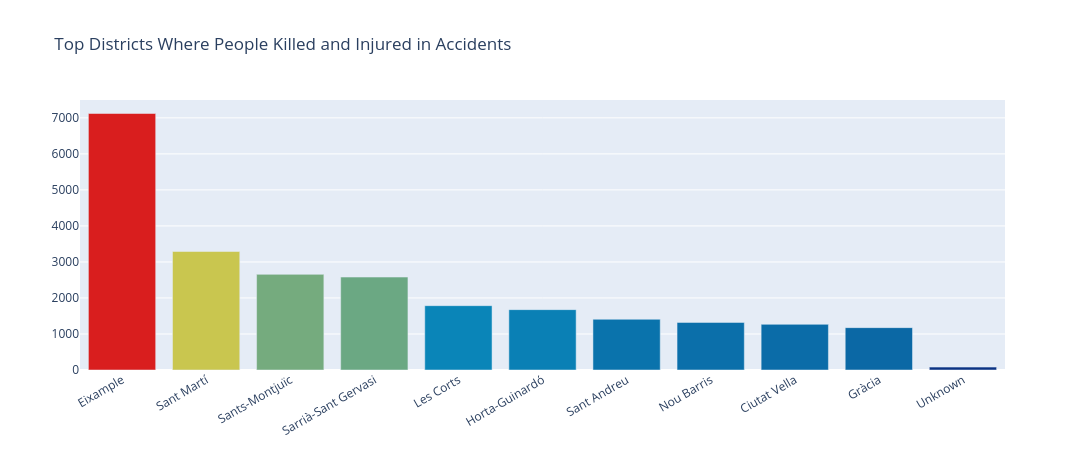

In [17]:
accidents['killed+injured'] = accidents['Mild injuries'] + accidents['Serious injuries'] + accidents['Victims']
temp_df = accidents.groupby(['District Name'])['killed+injured'].sum().sort_values(axis=0, ascending=False)

trace0 = go.Bar(x = temp_df.index,
                y = temp_df.values,
                marker = dict(color=list(temp_df.values),
                             colorscale='Portland')
                )

data = [trace0]
layout = go.Layout(xaxis = dict(tickangle=-30),
                   title="Top Districts Where People Killed and Injured in Accidents",
                      )
fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

In [18]:
population_in_districts = population[population['Year']==2017].groupby(['District.Name'])['Number'].sum()
cross_df = pd.merge(
    accidents[['District Name', 'killed+injured', 'Weekday']],
    population_in_districts,
    how='inner',
    left_on='District Name',
    right_on='District.Name')

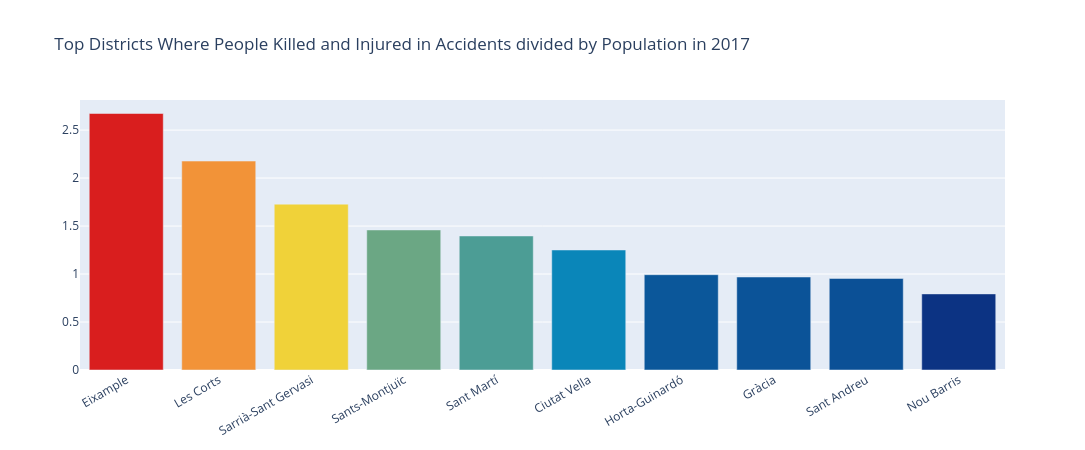

In [19]:
cross_df['prop_kill+inj'] = 100*cross_df['killed+injured'].astype(float)/cross_df['Number'].astype(float)
temp_df = cross_df.groupby(['District Name'])['prop_kill+inj'].sum().sort_values(axis=0, ascending=False)

trace0 = go.Bar(x = temp_df.index,
                y = temp_df.values,
                marker = dict(color=list(temp_df.values),
                             colorscale='Portland')
                )

data = [trace0]
layout = go.Layout(xaxis = dict(tickangle=-30),
                   title="Top Districts Where People Killed and Injured in Accidents divided by Population in 2017",
                      )
fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

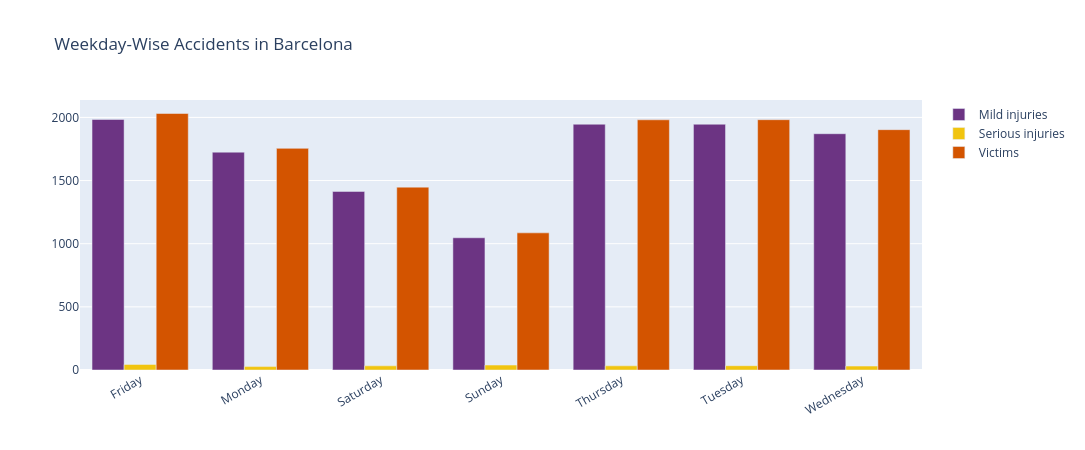

In [20]:
wkday = accidents.groupby(['Weekday']).\
        agg({'Mild injuries':'sum', 'Serious injuries':'sum','Victims':'sum'}).reset_index()
wkday

trace0 = go.Bar(x = wkday['Weekday'],
                y= wkday['Mild injuries'],
                name = "Mild injuries",
                marker = dict(color='rgb(108, 52, 131)')
               )

trace1 = go.Bar(x = wkday['Weekday'],
                y = wkday['Serious injuries'],
                name = "Serious injuries",
                marker = dict(color='rgb(241, 196, 15)')
               )

trace2 = go.Bar(x = wkday['Weekday'],
                y = wkday['Victims'],
                name = "Victims",
                marker = dict(color='rgb(211, 84, 0)')
               )

data = [trace0,trace1,trace2]
layout = go.Layout(barmode = 'group',
                   xaxis = dict(tickangle=-30),
                   title="Weekday-Wise Accidents in Barcelona",
                      )

fig = go.Figure(data=data,layout=layout)

plotly.offline.iplot(fig)

In [105]:
def plotGroupedSums(data, title, value_col, level_0_col, level_1_col, group_func='sum', autosize=True, t_width=None, t_height=None):
    if group_func == 'sum':
        deploy_df = data.groupby([level_0_col,level_1_col])[value_col].sum()
    elif group_func == 'mean':
        deploy_df = data.groupby([level_0_col,level_1_col])[value_col].mean()
    else:
        print('ERROR: group_func functions must be \'sum\' or \'mean\'.')
        
    level_0 = deploy_df.index.levels[0]
    level_1 = deploy_df.index.levels[1]

    plots_per_line = 2

    fig = make_subplots(
        math.ceil(level_1.size/plots_per_line), 
        plots_per_line, 
        subplot_titles=list(level_1.array))

    for i, elem in enumerate(level_1):
        fig.add_trace(
            go.Bar(
                x = level_0, 
                y = deploy_df.xs(elem, level=level_1_col).values,
                marker = dict(
                    color=list(deploy_df.xs(elem, level=level_1_col).values), 
                    colorscale='Reds'),
                name=elem), 
            int(i/plots_per_line) + 1,  # col
            1 + (i%plots_per_line))     # row 

    if not autosize:
        fig.update_layout(
            title_text=title,
            autosize=False,
            width=t_width,
            height=t_height
        )
    else:
        fig.update_layout(title_text=title)

    plotly.offline.iplot(fig)

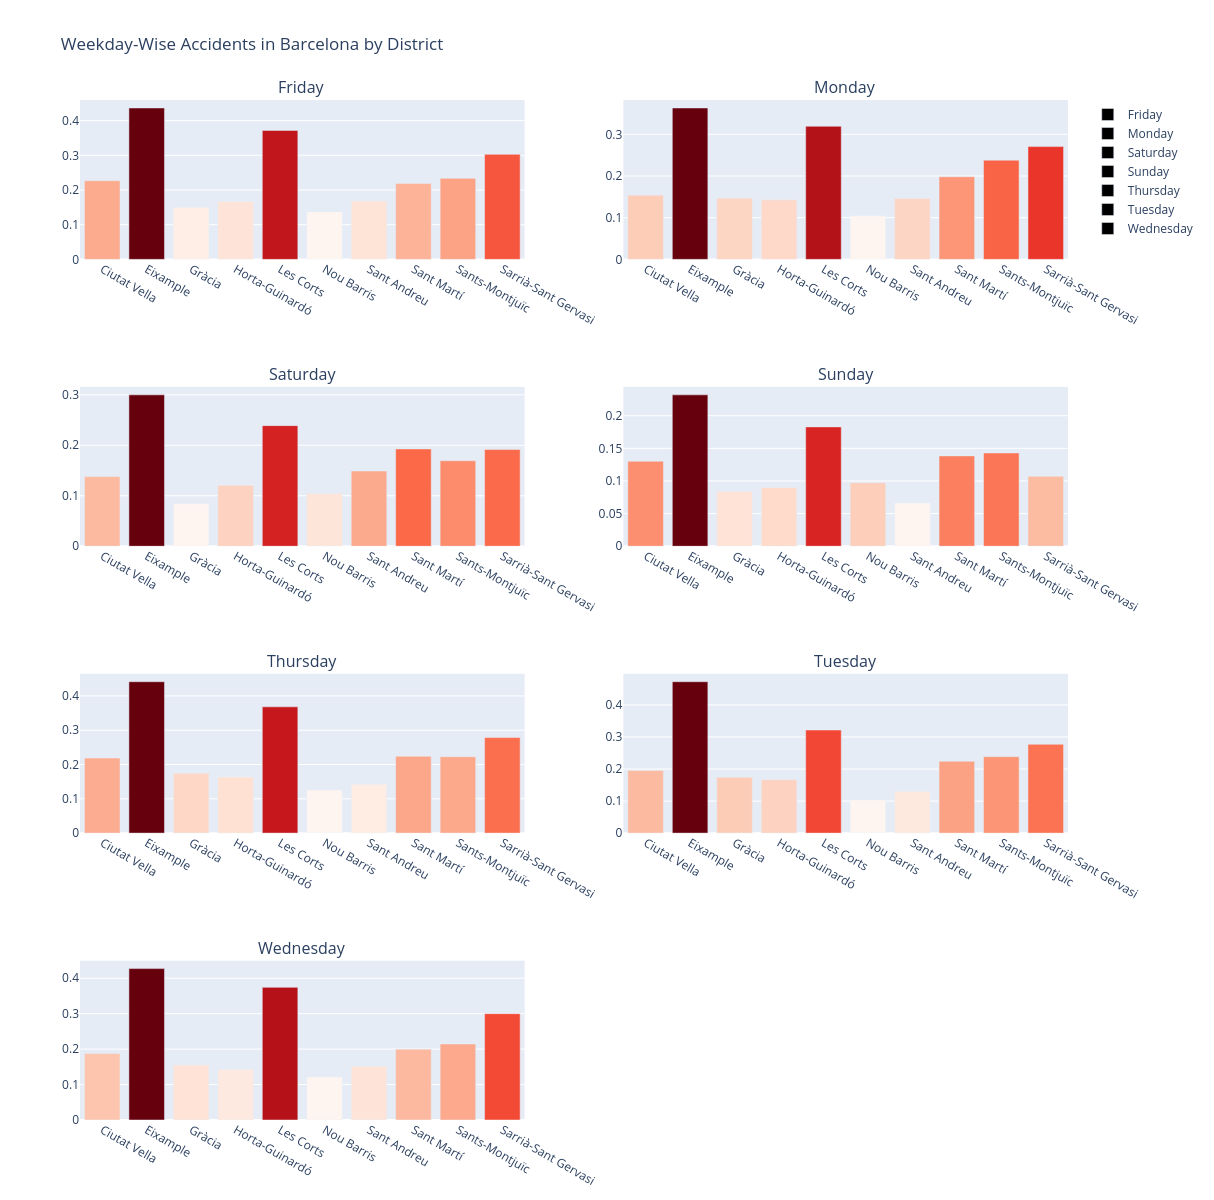

In [103]:
plotGroupedSums(
    cross_df,
    'Weekday-Wise Accidents in Barcelona by District',
    'prop_kill+inj',
    'District Name',
    'Weekday',
    autosize=False,
    t_width=1200,
    t_height=1200
)

## Barcelona accidents heatmap

In [23]:
barcelona_coordinates = [41.406141, 2.168594]

from folium.plugins import HeatMap

m = folium.Map(location=barcelona_coordinates, tiles='CartoDB Dark_Matter', zoom_start=13)

lat_long_df = accidents[['Latitude','Longitude']]

lat_long = [[row['Latitude'],row['Longitude']] for index,row in lat_long_df.iterrows()]

#map_accidents.add_children(plugins.HeatMap(lat_long))

HeatMap(lat_long, min_opacity=0.5, radius=15).add_to(m)

m

## Air Quality (Year 2017)

In [24]:
airquality = pd.read_csv('./data/air_quality_Nov2017.csv')
airquality.head()

Station Air Quality  Longitude  Latitude O3 Hour  \
0        Barcelona - Sants        Good     2.1331   41.3788     NaN   
1     Barcelona - Eixample    Moderate     2.1538   41.3853      0h   
2       Barcelona - Gràcia        Good     2.1534   41.3987      0h   
3   Barcelona - Ciutadella        Good     2.1874   41.3864      0h   
4  Barcelona - Vall Hebron        Good     2.1480   41.4261      0h   

  O3 Quality  O3 Value NO2 Hour NO2 Quality  NO2 Value PM10 Hour PM10 Quality  \
0        NaN       NaN       0h        Good       84.0       NaN          NaN   
1       Good       1.0       0h    Moderate      113.0        0h         Good   
2       Good      10.0       0h        Good       73.0       NaN          NaN   
3       Good       2.0       0h        Good       86.0       NaN          NaN   
4       Good       7.0       0h        Good       69.0       NaN          NaN   

   PM10 Value        Generated   Date Time  
0         NaN  01/11/2018 0:00  1541027104  
1        36.0  01/11/2018 0:00  1541027104  
2         NaN  01/11/2018 0:00  1541027104  
3         NaN  01/11/2018 0:00  1541027104  
4         NaN  01/11/2018 0:00  1541027104

In [25]:
airquality.describe()

Longitude       Latitude     O3 Value    NO2 Value   PM10 Value  \
count  5744.00000    5744.000000  4101.000000  5460.000000  3647.000000   
mean      2.15240   13877.827714    34.082907    35.740293    16.590074   
std       0.02859   74410.803168    22.960687    22.357262     8.065424   
min       2.11510      41.378800     1.000000     1.000000     2.000000   
25%       2.13080      41.386400    14.000000    17.000000    10.000000   
50%       2.15070      41.398700    34.000000    33.000000    15.000000   
75%       2.16220      41.418300    52.000000    52.000000    22.000000   
max       2.20450  414261.000000   100.000000   117.000000    44.000000   

          Date Time  
count  5.744000e+03  
mean   1.542323e+09  
std    7.483961e+05  
min    1.541027e+09  
25%    1.541675e+09  
50%    1.542325e+09  
75%    1.542971e+09  
max    1.543616e+09

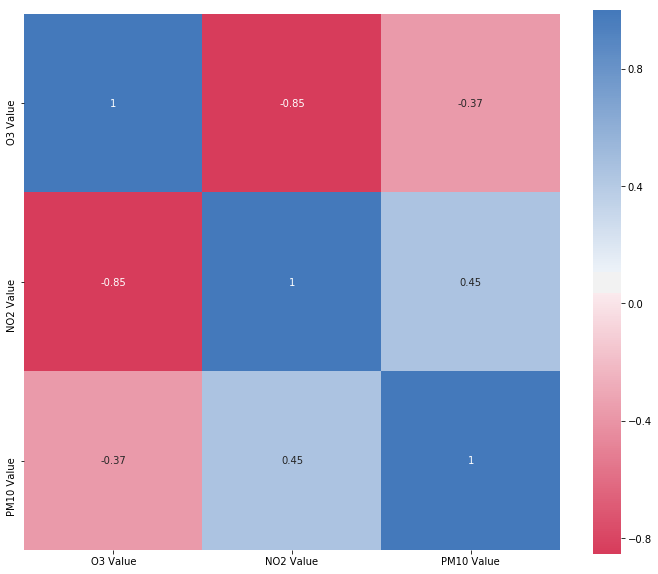

In [41]:
corr = airquality[['O3 Value', 'NO2 Value', 'PM10 Value']].corr()

# plot the heatmap
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns,
    cmap=sns.diverging_palette(5, 250, as_cmap=True),
    annot=True,
    square=True,
    ax=ax
)

In [50]:
airquality['Generated'] = pd.to_datetime(airquality['Generated']) 

In [51]:
airquality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5744 entries, 0 to 5743
Data columns (total 15 columns):
Station         5744 non-null object
Air Quality     5744 non-null object
Longitude       5744 non-null float64
Latitude        5744 non-null float64
O3 Hour         4268 non-null object
O3 Quality      4268 non-null object
O3 Value        4101 non-null float64
NO2 Hour        5689 non-null object
NO2 Quality     5689 non-null object
NO2 Value       5460 non-null float64
PM10 Hour       3722 non-null object
PM10 Quality    3722 non-null object
PM10 Value      3647 non-null float64
Generated       5744 non-null datetime64[ns]
Date Time       5744 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(8)
memory usage: 673.2+ KB


In [74]:
airquality['Station'].describe()

count                   5744
unique                     8
top       Barcelona - Gràcia
freq                     718
Name: Station, dtype: object

In [75]:
airquality['Generated'].describe()

count                    5744
unique                    714
top       2018-11-15 12:00:00
freq                       16
first     2018-01-11 00:00:00
last      2018-12-11 23:00:00
Name: Generated, dtype: object

In [77]:
# df1[df1.a>datetime.datetime(2011,1,14)]
airquality_december = airquality[
    (airquality['Generated']>=datetime.datetime(2018,12,1)) &
    (airquality['Generated']<=datetime.datetime(2018,12,31))
]
airquality_december.describe()

Longitude    Latitude    O3 Value   NO2 Value  PM10 Value  \
count  192.000000  192.000000  143.000000  191.000000  120.000000   
mean     2.152400   41.398125   33.174825   40.099476   20.141667   
std      0.028662    0.015899   27.191629   20.298186    6.360720   
min      2.115100   41.378800    1.000000    3.000000   10.000000   
25%      2.130800   41.386125    3.000000   23.000000   16.000000   
50%      2.150700   41.393100   34.000000   38.000000   19.000000   
75%      2.162200   41.407500   54.000000   56.000000   23.000000   
max      2.204500   41.426100   90.000000   98.000000   36.000000   

          Date Time  
count  1.920000e+02  
mean   1.542019e+09  
std    2.498469e+04  
min    1.541978e+09  
25%    1.541998e+09  
50%    1.542019e+09  
75%    1.542040e+09  
max    1.542060e+09

In [95]:
airquality['Weekday'] = airquality['Generated'].dt.day_name()
airquality['Month'] = airquality['Generated'].dt.month_name()

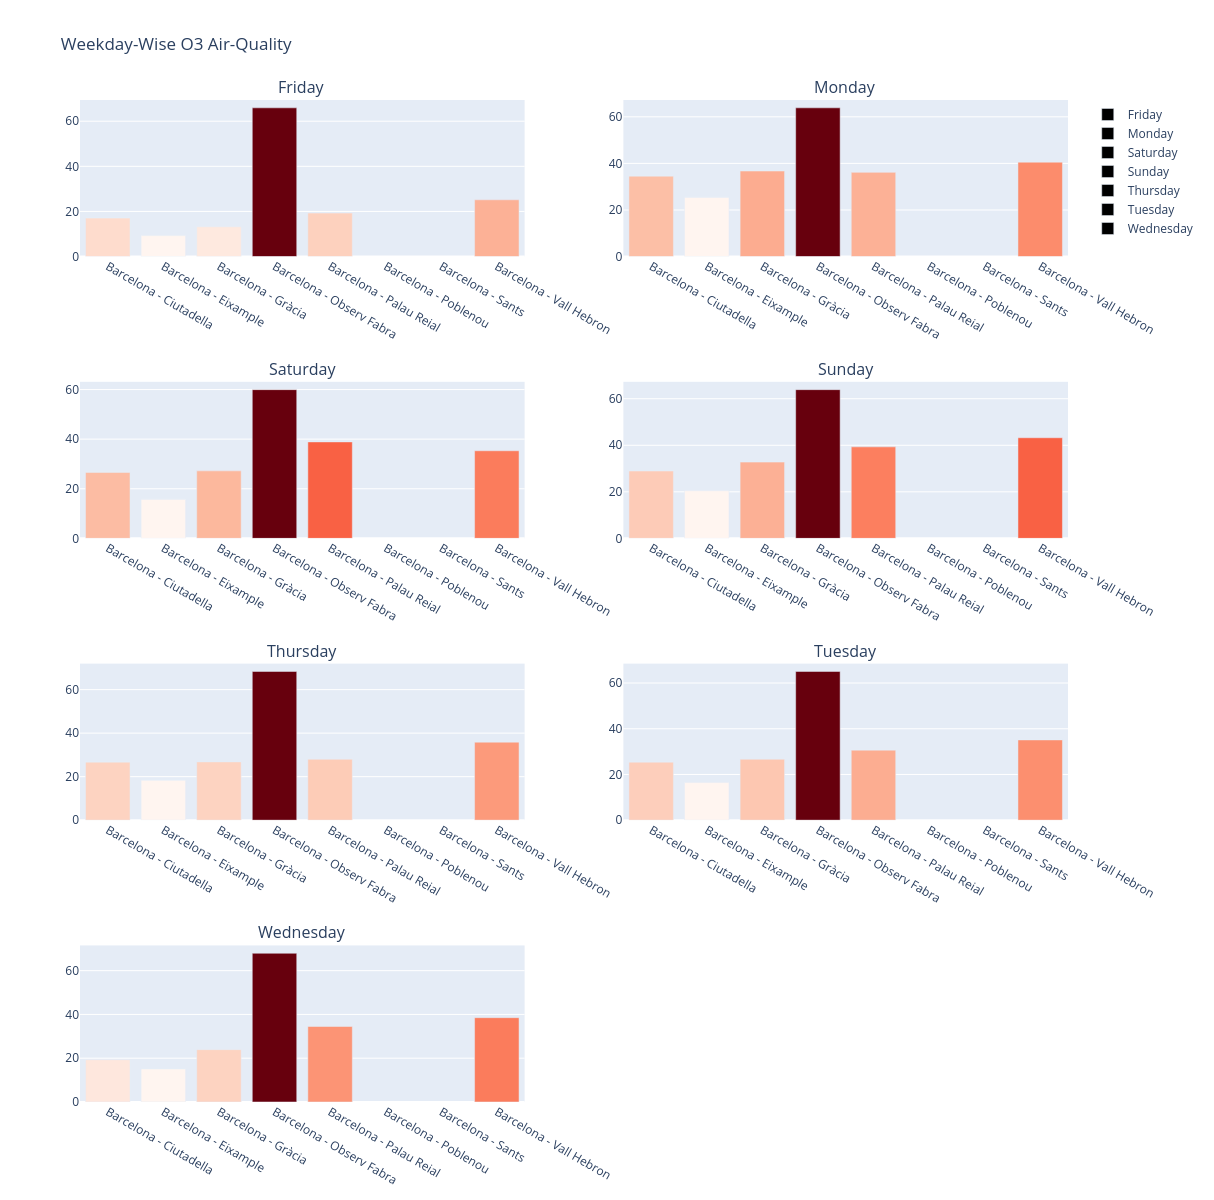

In [106]:
plotGroupedSums(
    airquality,
    'Weekday-Wise O3 Air-Quality',
    'O3 Value',
    'Station',
    'Weekday',
    group_func='mean',
    autosize=False,
    t_width=1200,
    t_height=1200
)